># GPT4 Vision+Langchain

## Installing libraries

In [ ]:
#installing dependencies for GPT4 Vision+Langchain for extracting insights from invoice
!pip install langchain langchain_openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.3/291.3 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.2/115.2 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: pa

## Invoice details extraction

In [ ]:
#loading all the necessary libraries
import os
import langchain
import requests
import base64
import pandas as pd
from langchain.chains import TransformChain
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.messages import HumanMessage
from langchain.chains import TransformChain
from langchain_openai import ChatOpenAI
from langchain import globals
from langchain_core.runnables import chain
from langchain_core.output_parsers import JsonOutputParser

In [ ]:
os.environ["OPENAI_API_KEY"]="YOUR_API_KEY"

In [ ]:
#To encode the image in base64
#Function to encode the image
def load_image(inputs: dict) -> dict:
    """Load image from file and encode it as base64."""
    image_path = inputs["image_path"]
    def encode_image(image_path):
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    image_base64 = encode_image(image_path)
    return {"image": image_base64}

In [ ]:
load_image_chain = TransformChain(input_variables=["image_path"],output_variables=["image"],transform=load_image)

In [ ]:
class ImageInformation(BaseModel):
 """Information about an image."""
 Name: str = Field(description="""Name of the merchant. It can be directly from merchant or a service provider.
                                  Always extarct complete name of the merchant and translate any language to English.""")
 Amount: str = Field(description="""How much amount was the final transaction made for?
                                    Always add the respective currency symbol.
                                    Convert the words to respective currency symbol.
                                    Example: input: Rs.100, correct output: ₹100 """) #it can be in int and float values
 Date: str = Field(description="""What date the transaction was made?
                                  It should be in DD-MM-YYYY format.
                                  Example: input: 2023-07-11, correct output: 11-07-2023.""")
 Receipt_num: str = Field(description="""What is the bill number / invoice number / transaction ID / receipt number?
                                         It can be alphanumeric. It should be as seen on the invoice.""")

In [ ]:
# Set verbose
globals.set_debug(True)
@chain
def image_model(inputs: dict) -> str | list[str] | dict:
 """Invoke model with image and prompt."""
 model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)
 msg = model.invoke(
             [HumanMessage(
             content=[
             {"type": "text", "text": inputs["prompt"]},
             {"type": "text", "text": parser.get_format_instructions()},
             {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{inputs['image']}"}},
             ])]
             )
 return msg.content

In [ ]:
parser = JsonOutputParser(pydantic_object=ImageInformation)
def get_image_informations(image_path: str) -> dict:
   vision_prompt = """
   Given the image, provide the transaction details as follows:
   - Name on the receipt for which the transaction is being made
   - Date of transaction
   - Amount of transaction made
   - Invoice number of the transaction
   The output should always be consistent with all details as expected.
   It should also be same all the time.
   """
   vision_chain = load_image_chain | image_model | parser
   return vision_chain.invoke({'image_path': f'{image_path}',
                               'prompt': vision_prompt})

Enter image file path: /content/1-930342a738.jpg
[chain/start] [1:chain:RunnableSequence] Entering Chain run with input:
{
  "image_path": "/content/1-930342a738.jpg",
  "prompt": "\n   Given the image, provide the transaction details as follows:\n   - Name on the receipt for which the transaction is being made\n   - Date of transaction\n   - Amount of transaction made\n   - Invoice number of the transaction\n   The output should always be consistent with all details as expected.\n   It should also be same all the time.\n   "
}
[chain/start] [1:chain:RunnableSequence > 2:chain:TransformChain] Entering Chain run with input:
{
  "image_path": "/content/1-930342a738.jpg",
  "prompt": "\n   Given the image, provide the transaction details as follows:\n   - Name on the receipt for which the transaction is being made\n   - Date of transaction\n   - Amount of transaction made\n   - Invoice number of the transaction\n   The output should always be consistent with all details as expected.\n   I
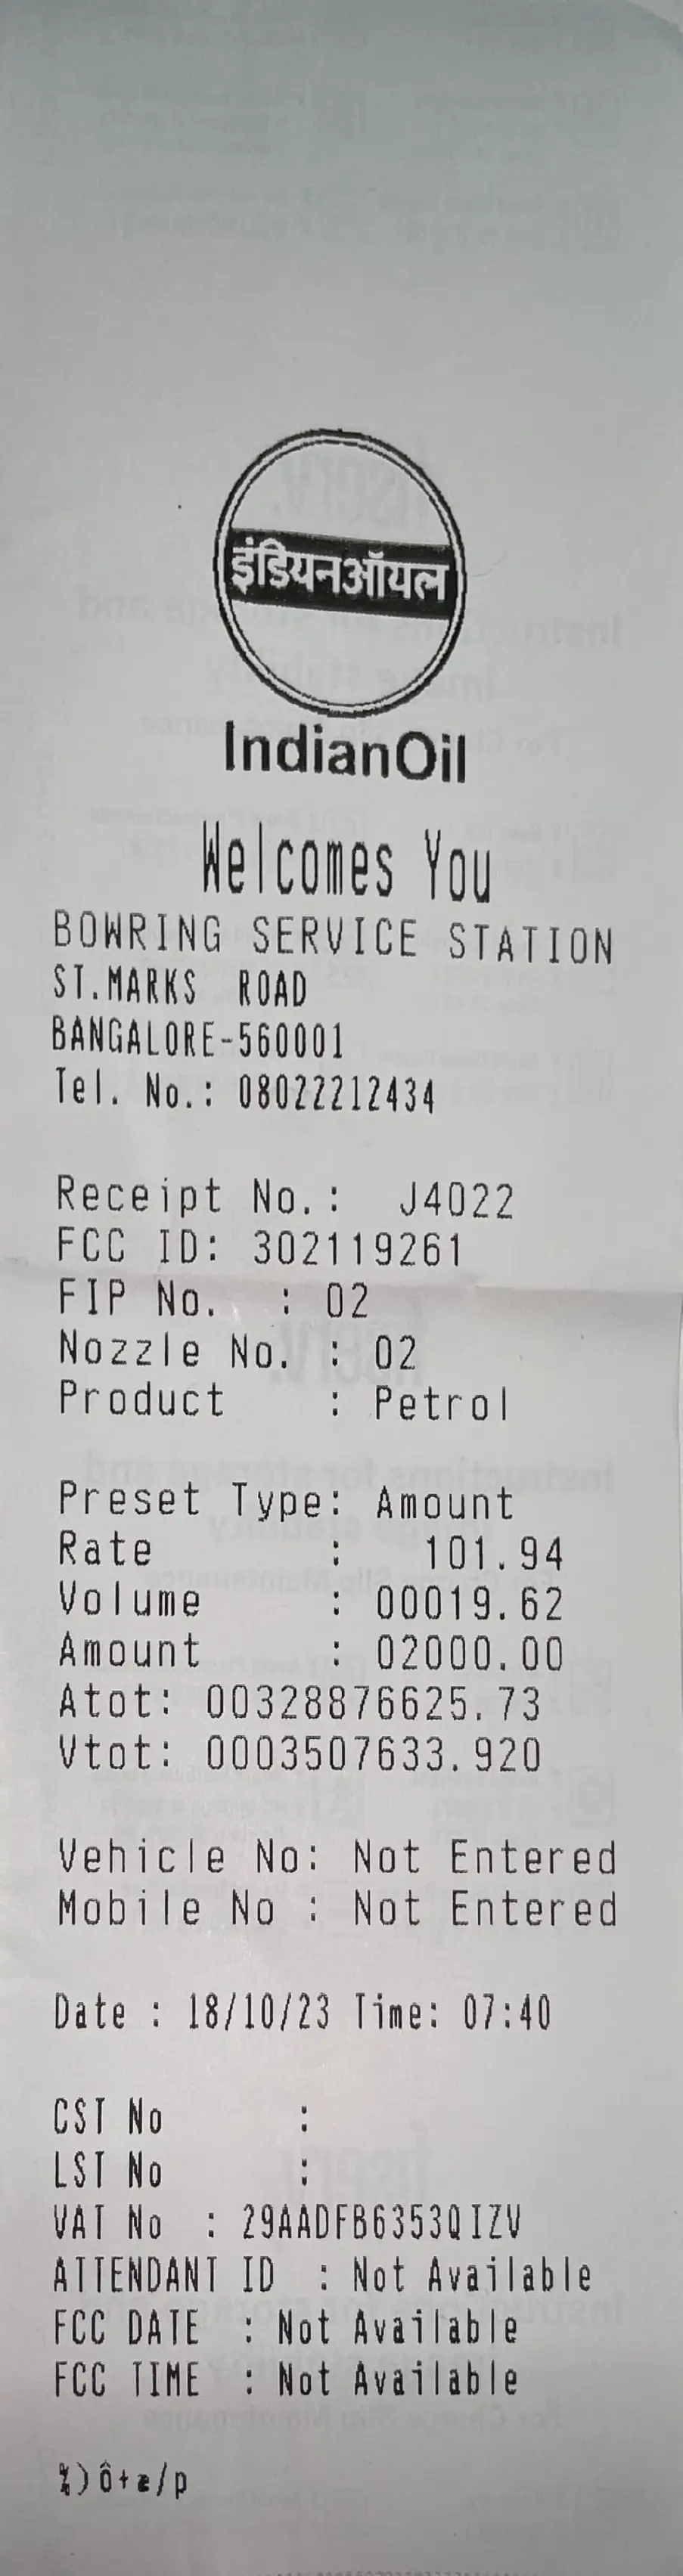

In [ ]:
#images of invoices have been taken from Google Images
result = get_image_informations(input("Enter image file path: "))
print(result)

In [ ]:
_dict=dict_output=result

In [ ]:
df=pd.DataFrame(list(dict_output.items()),columns=['Invoice Details','Values'])
df

,Invoice Details,Values
0,Name,Indian Oil - Bowring Service Station
1,Amount,₹2000.00
2,Date,18-10-2023
3,Receipt_num,J4022
